/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 2.0.0               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported GetDist version: 1.4
Imported nestcheck version: 0.2.1
E: failed to import some OS environment variables, using defaults.
machine:  local
num_energies:  128
num_leaves:  128
sqrt_num_cells:  128
integrator: azimuthal_invariance
interpolator: split
Rank reporting: 0
Setting channels for event data...
Channels set.
Setting channels for loaded instrument response (sub)matrix...
Channels set.
No parameters supplied... empty subspace created.
Creating parameter:
    > Named "frequency" with fixed value 4.010e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e+00, 3.000e+00].
    > Gravitational mass [solar masses

Executing posterior density estimation...
Curating set of runs for posterior plotting...
Run set curated.
Constructing lower-triangle posterior density plot via Gaussian KDE:
plotting:  ['mass', 'radius']
plotting:  ['mass', 'distance']
plotting:  ['mass', 'cos_inclination']
plotting:  ['mass', 'p__phase_shift']
plotting:  ['mass', 'p__super_colatitude']
plotting:  ['mass', 'p__super_radius']
plotting:  ['mass', 'p__super_tbb']
plotting:  ['mass', 'p__super_te']
plotting:  ['mass', 'p__super_tau']
plotting:  ['mass', 'elsewhere_temperature']
plotting:  ['mass', 'column_density']
plotting:  ['mass', 'compactness']
plotting:  ['radius', 'distance']
plotting:  ['radius', 'cos_inclination']
plotting:  ['radius', 'p__phase_shift']
plotting:  ['radius', 'p__super_colatitude']
plotting:  ['radius', 'p__super_radius']
plotting:  ['radius', 'p__super_tbb']
plotting:  ['radius', 'p__super_te']
plotting:  ['radius', 'p__super_tau']
plotting:  ['radius', 'elsewhere_temperature']
plotting:  ['radiu

Signal caching loop:   0%|          | 0/3 [00:00<?, ?it/s]

ResidualPlot object iterating over samples...
ResidualPlot object finished iterating.
ResidualPlot object finalizing...
ResidualPlot object finalized.
Writing plot to disk...
ResidualPlot instance plot will be written to path ./ST.no_poisson_lp192__signalplot_residuals.pdf...
Written.
Handled posterior ST.
Plotted signals for posterior checking.


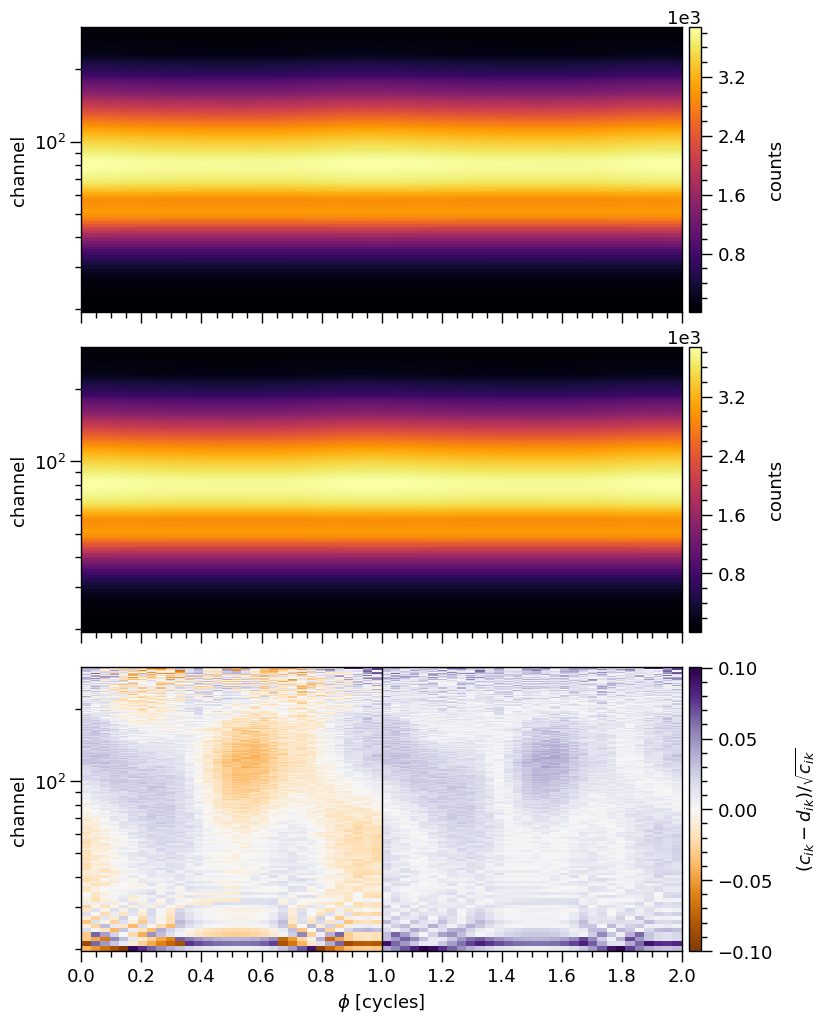

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Apr 11 10:48:58 2023

@author: bas, much copied from postprocessing tutorial
"""

# Importing relevant modules

# %matplotlib inline

# from __future__ import division

import sys
import os
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, AutoLocator, AutoMinorLocator
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import math

from collections import OrderedDict

import xpsi

from xpsi import PostProcessing

# choose a seed for the notebook if you want caching to be useful
# and the notebook exactly reproducible
PostProcessing.set_random_seed(42)

from xpsi.global_imports import gravradius


path="../../"
sys.path.append(path)
import main as ST

# To compare poisson vs no poisson, remake synthetic data. with correct customsignal.

# job_id = 4879768
# job_label = 'poisson_lp192'

job_id = 4960988
job_label = 'no_poisson_lp192'
run_ID = job_label



# We will use the same bounds used during sampling

# Settings names, bounds and labels
ST.names=['mass','radius','distance','cos_inclination','p__phase_shift','p__super_colatitude','p__super_radius','p__super_tbb','p__super_te','p__super_tau','elsewhere_temperature','column_density']

ST.bounds = {'mass':(1.0,3.0),
             'radius':(3.0 * gravradius(1.0), 16.0),
             'distance':(3.4, 3.6),
             'cos_inclination':(0.,1.),
             'p__phase_shift':(-0.25, 0.75),
             'p__super_colatitude':(0.001, math.pi - 0.001),
             'p__super_radius':(0.001, math.pi/2.0 - 0.001),
             'p__super_tbb':(0.001, 0.003),
             'p__super_te': (40., 200.),
             'p__super_tau': (0.5, 3.5),
             'elsewhere_temperature': (6.5, 7.),
             'column_density': (0., 3.)}


# Now the labels
ST.labels = {'mass': r"M\;\mathrm{[M}_{\odot}\mathrm{]}",
              'radius': r"R_{\mathrm{eq}}\;\mathrm{[km]}",
              'distance': r"D \;\mathrm{[kpc]}",
              'cos_inclination': r"\cos(i)",
              'p__phase_shift': r"\phi_{p}\;\mathrm{[cycles]}",
              'p__super_colatitude': r"\Theta_{spot}\;\mathrm{[rad]}",
              'p__super_radius': r"\zeta_{spot}\;\mathrm{[rad]}",
              'p__super_tbb': r"t_{bb}\;\mathrm{[data units]}",
              'p__super_te': r"t_e data units",
              'p__super_tau': "tau unitless",
              'elsewhere_temperature': r"T_e log10 of Kelvin",
              'column_density': r"n_H 10\^21 cm\^{-2}"}

ST.truths={'mass': 1.4,                               # Mass in solar Mass
          'radius': 12.,                              # Equatorial radius in km
          'distance': 3.5,                            # Distance in kpc
          'cos_inclination': math.cos(math.pi*60/180),          # Cosine of Earth inclination to rotation axis
          'p__phase_shift': 0.0,                    # Phase shift
          'p__super_colatitude': 45*math.pi/180,                # Colatitude of the centre of the superseding region
          'p__super_radius': 15.5*math.pi/180,                 # Angular radius of the (circular) superseding region
          'p__super_tbb': 0.0012,                      # Blackbody temperature
          'p__super_te': 100.,                          # Electron temperature
          'p__super_tau': 1.,
          'elsewhere_temperature': 6.67,
          'column_density': 1.17}

ST.truths['compactness']=gravradius(ST.truths['mass'])/ST.truths['radius']

#### SOMETHING SOMETHING COMPACTNESS

ST.names +=['compactness']
ST.bounds['compactness']=(gravradius(1.0)/16.0, 1.0/3.0)
ST.labels['compactness']= r"M/R_{\mathrm{eq}}"

getdist_kde_settings = {'ignore_rows': 0,
                        'min_weight_ratio': 1.0e-10,
                        'contours': [0.683, 0.954, 0.997],
                        'credible_interval_threshold': 0.001,
                        'range_ND_contour': 0,
                        'range_confidence': 0.001,
                        'fine_bins': 1024,
                        'smooth_scale_1D': 0.4,
                        'num_bins': 100,
                        'boundary_correction_order': 1,
                        'mult_bias_correction_order': 1,
                        'smooth_scale_2D': 0.4,
                        'max_corr_2D': 0.99,
                        'fine_bins_2D': 512,
                        'num_bins_2D': 40}

print('names',ST.names)
print('likelihood:', ST.likelihood)



ST.runs = xpsi.Runs.load_runs(ID='ST',
                               run_IDs=[run_ID],
                               roots=[f'run_ST_'],
                               base_dirs=[f'/home/bas/Documents/Projects/x-psi/xpsi-bas-fork/AMXPs/J1808_synthetic/snellius_runs/{job_label}/{job_id}/{job_label}'],
                               use_nestcheck=[False],
                               kde_settings=getdist_kde_settings,
                               likelihood=ST.likelihood,
                               names=ST.names,
                               bounds=ST.bounds,
                               labels=ST.labels,
                               truths=ST.truths,
                               implementation='multinest',
                               overwrite_transformed=True)


pp = xpsi.PostProcessing.CornerPlotter([ST.runs])
fig = pp.plot(
     params=ST.names,
     IDs=OrderedDict([('ST', [run_ID,]),]),
     prior_density=False,
     KL_divergence=True,
     ndraws=5e4,
     combine=False, combine_all=True, only_combined=False, overwrite_combined=True,
     param_plot_lims={},
     bootstrap_estimators=False,
     bootstrap_density=False,
     n_simulate=200,
     crosshairs=True,
     write=True,
     ext='.png',
     maxdots=3000,
     root_filename=f'run',
     credible_interval_1d=True,
     annotate_credible_interval=True,
     compute_all_intervals=False,
     sixtyeight=True,
     axis_tick_x_rotation=45.0,
     num_plot_contours=3,
     subplot_size=4.0,
     legend_corner_coords=(0.675,0.8),
     legend_frameon=False,
     scale_attrs=OrderedDict([('legend_fontsize', 2.0),
                              ('axes_labelsize', 1.35),
                              ('axes_fontsize', 'axes_labelsize'),
                             ]
                            ),
     colormap='Reds',
     shaded=True,
     shade_root_index=-1,
     rasterized_shade=True,
     no_ylabel=True,
     no_ytick=True,
     lw=1.0,
     lw_1d=1.0,
     filled=False,
     normalize=True,
     veneer=True,
     #contour_colors=['orange'],
     tqdm_kwargs={'disable': False},
     lengthen=2.0,
     embolden=1.0,
     nx=500)

pp = xpsi.SignalPlotter([ST.runs])
pp.plot(IDs=OrderedDict([('ST', [run_ID]),
                        ]),
        combine=False, # use these controls if more than one run for a posterior
        combine_all=False,
        force_combine=False,
        only_combined=False,
        force_cache=True,
        nsamples=3,
        plots = {'ST': xpsi.ResidualPlot()})

pp.plots["ST"].fig


#%%

# plt.savefig(f'./corner_run_se={sampling_efficiency}_lp={live_points}_atm={atmosphere_type}{n_params}_ne={num_energies}_mi={max_iterations}.png')



In [5]:
P_Original = ST.p
ST.likelihood(ST.p)
print(P_Original)

[1.4, 12.0, 3.5, 0.5000000000000001, 0, 0.7853981633974483, 0.27052603405912107, 0.0012, 100.0, 1.0, 6.66668724957777, 1.17]


# max_L

In [3]:
P_MaxL_NP_192 = [0.159541871493433973E+01,
0.103217607341850268E+02,
0.348596939961232444E+01,
0.546166856071860551E+00,
-0.528761454159420996E-02,
0.105021979369667684E+01,
0.313327751326617054E+00,
0.129295039715317858E-02,
0.415074685360910678E+02,
0.153428372501099131E+01,
0.666247831762742670E+01,
0.100173397883003434E+01]

In [4]:
ST.likelihood(P_MaxL_NP_192)

-42062.298567295766